In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Load data

In [45]:
mb_raw_data = pd.read_csv('../../data/mann_bruker.txt', sep='\t')

# Keep only necessary columns
mb_clean_frame = mb_raw_data[['Sequence', 'm/z', 'CCS','Mass','Charge','Length']]

# Perform z-score transformation
mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])

# save mean and standard deviation for later
ccs_mean = mb_clean_frame['CCS'].mean()
ccs_std = mb_clean_frame['CCS'].std()

#randomize dataset
mb_clean_frame = mb_clean_frame.sample(random_state=1, frac=1)


/var/folders/sr/wyqzncnn2vd6vrgm99v9cz7w0000gp/T/ipykernel_2750/4211861358.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])


First: Train base model (no charge separation)
Train either this or the "Second" below, with charge separation


In [46]:
# Split data into input and output variables
X = mb_clean_frame[['Mass', 'Charge', 'Length']]
y = mb_clean_frame[['CCS_z']]
# Define the number of folds
k = 4

Perform k-fold cross validation


In [47]:
# Start logging time
start_time = time.time()
# Initialize K-fold object
k_fold = KFold(n_splits=k)

# Initialize lists to store statistics for each fold
mse_scores = []
median_relative_errors = []
r2_scores = []

# Perform k-fold cross validation
for train_index, test_index in k_fold.split(X):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create a lin reg regression model
    model = LinearRegression(n_jobs=-1)

    # train model
    model.fit(X_train, y_train)

    # make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the MSE for the current fold
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    # Calculate the median relative error for the current fold
    relative_errors = np.abs((y_pred - y_test) / y_test)
    median_relative_error = np.median(relative_errors)
    median_relative_errors.append(median_relative_error)
    # Calculate the R^2 score for the current fold
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    # Progress update
    print("Fold:", len(mse_scores))

# Create the final model
final_model = LinearRegression(n_jobs=-1)
final_model.fit(X, y)
# Print all mse scores
#print("All Mean Squared Errors:", mse_scores)
# Average the MSE scores
average_mse = np.mean(mse_scores)
# Print the average MSE score
print("Average Mean Squared Error:", average_mse)
# Print the median of the relative errors for each fold
#print("Median Relative Errors:", median_relative_errors)
# print the average of the median relative errors
print("Average Median Relative Error:", np.mean(median_relative_errors))
# Print the R^2 scores for each fold
#print("R^2 Scores:", r2_score)
# Print the average R^2 score
print("Average R^2 Score:", np.mean(r2_scores))
# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Print the elapsed time
print(f'Time elapsed: {elapsed_time:.2f} seconds')

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 0.016311789212782694
Average Median Relative Error: 0.11223354158816626
Average R^2 Score: 0.9836873562407771
Time elapsed: 0.20 seconds


Learning curve


In [ ]:
from sklearn.model_selection import learning_curve

# Define the sizes of the training sets to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    LinearRegression(n_jobs=-1),
    X,
    y,
    train_sizes=train_sizes,
    cv=k,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate the average training and test scores
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel('Training set size')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance, color="#3070B3")
plt.title("Feature Importance")
features = X.columns
plt.xticks(range(X.shape[1]), model.feature_names_in_, rotation=0)
plt.xlim([-1, X.shape[1]])
plt.show()

Save the model

In [48]:
# Predict CCS values in dataframe
mb_clean_frame['Predicted CCS_z'] = final_model.predict(X)

# Reverse z score transformation
mb_clean_frame['Predicted CCS'] = mb_clean_frame['Predicted CCS_z'] * ccs_std + ccs_mean

In [49]:
mb_clean_frame

,Sequence,m/z,CCS,Mass,Charge,Length,CCS_z,Predicted CCS_z,Predicted CCS
67932,DWFILDHVSFDTLR,882.441212,1.493938e-35,1762.867870,2,14,-0.137390,-0.072192,1.545415e-35
326165,QRPTNGKNDGQR,685.847813,1.708089e-35,1369.681070,2,12,0.133841,0.170938,1.737379e-35
379127,TLFSTHYHSLVEDYSQNVAVR,822.739789,2.534496e-35,2465.197540,3,21,1.180520,1.208821,2.556842e-35
67996,DWLVPETFTK,412.548406,3.333980e-35,1234.623390,3,10,2.193100,2.008750,3.188428e-35
202778,KVEEDLK,860.472374,6.068834e-36,859.465098,1,7,-1.260881,-1.237283,6.255146e-36
...,...,...,...,...,...,...,...,...,...
73349,EDFEEAR,895.379202,6.106416e-36,894.371926,1,7,-1.256121,-1.257407,6.096254e-36
371403,TEDEAVYKAK,577.290411,1.899919e-35,1152.566270,2,10,0.376802,0.312560,1.849197e-35
312201,PWRAFFK,476.263605,2.012036e-35,950.512657,2,7,0.518803,0.453724,1.960654e-35
267336,MVNPTVFFDIAVDGEPLGR,1039.024780,1.387200e-35,2076.035010,2,19,-0.272578,-0.293867,1.370391e-35


In [ ]:
# Create a scatter plot of the error between the predicted and actual CCS values by sequence length. X = Experimental CCS, Y = Predicted CCS, Color = Sequence Length, Colormap = cool, alpha = 0.01
mb_clean_frame.plot.scatter(
    x='CCS',
    y='Predicted CCS',
    c='Length',
    cmap='winter',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)
mb_clean_frame.plot.hexbin(
    x='CCS',
    y='Predicted CCS',
    C='Length',
    reduce_C_function=np.mean,
    gridsize=50,
    cmap='magma'
)

# Print the Spearman's correlation coefficient between the predicted and actual CCS values
print("Spearman's Correlation Coefficient:", mb_clean_frame['CCS'].corr(mb_clean_frame['Predicted CCS'], method='spearman'))
# Create a scatter plot between the percent error and length
mb_clean_frame['Percent Error'] = np.abs((mb_clean_frame['Predicted CCS'] - mb_clean_frame['CCS']) / mb_clean_frame['CCS'])
mb_clean_frame.plot.scatter(
    x='Length',
    y='Percent Error',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)

Calculate errors with z_transformed CCS values


In [128]:
absolute_errors = mb_clean_frame['CCS_z'] - mb_clean_frame['Predicted CCS_z']
mb_clean_frame['Absolute Errors_z'] = absolute_errors

squared_errors = (mb_clean_frame['CCS_z'] - mb_clean_frame['Predicted CCS_z'])**2
mb_clean_frame['Squared Errors_z'] = squared_errors

Plot error distribution to check what error metric makes sense


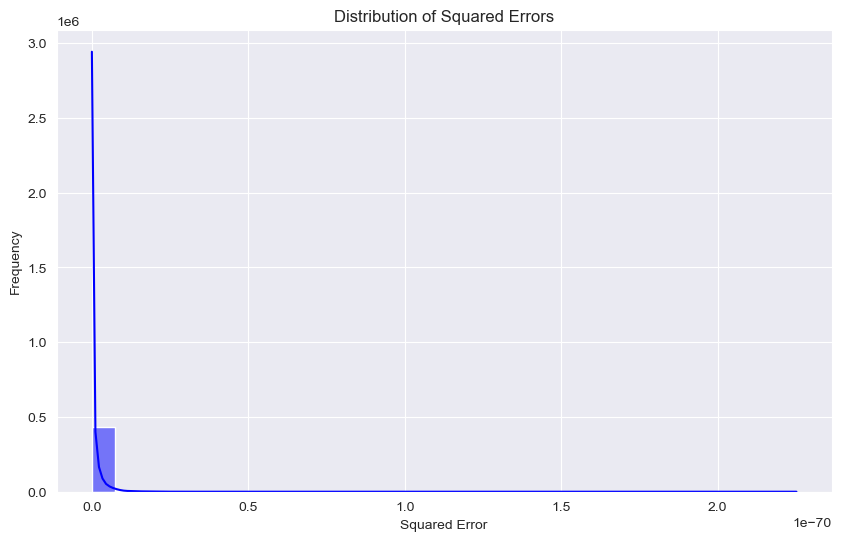

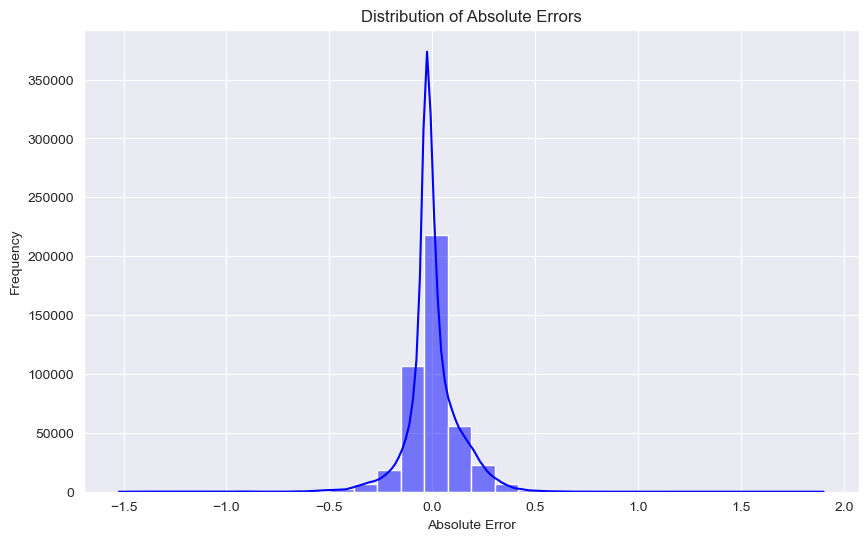

In [115]:
# Plotting the distribution of squared errors
plt.figure(figsize=(10, 6))
sns.histplot(squared_errors, kde=True, bins=30, color='blue')
plt.title('Distribution of Squared Errors')
plt.xlabel('Squared Error')
plt.ylabel('Frequency')
plt.show()

# Plotting the distribution of absolute errors
plt.figure(figsize=(10, 6))
sns.histplot(absolute_errors, kde=True, bins=30, color='blue')
plt.title('Distribution of Absolute Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.show()

Distribution looks quite centered, so we just train on absolute errors

Train either model for predicting absolute errors

In [124]:
# Split data into input and output variables
X = mb_clean_frame[['Mass', 'Charge', 'Length']]
y = mb_clean_frame['Absolute Errors_z']
# Define the number of folds
k = 4
# Number of trees
n = 60

Or train model for predicting squared errors

In [131]:
# Split data into input and output variables
X = mb_clean_frame[['Mass', 'Charge', 'Length']]
y = mb_clean_frame['Squared Errors_z']
# Define the number of folds
k = 4
# Number of trees
n = 30

In [132]:
# Start logging time in ms without
start_time = time.time()
# Initialize the cross-validation object
kf = KFold(n_splits=k)
# Initialize a list to store the MSE for each fold
mse_scores = []
median_relative_errors = []
r2_scores = []
# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Create a random forest regressor model
    model = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the MSE for the current fold
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    # Calculate the median relative error for the current fold
    relative_errors = np.abs((y_pred - y_test) / y_test)
    median_relative_error = np.median(relative_errors)
    median_relative_errors.append(median_relative_error)
    # Calculate the R^2 score for the current fold
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    # Progress update
    print("Fold:", len(mse_scores))

# Create the final model
final_model = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1)
final_model.fit(X, y)

# Print the average MSE score
print("Average Mean Squared Error:", np.mean(mse_scores))
# print the average of the median relative errors
print("Average Median Relative Error:", np.mean(median_relative_errors))
# Print the average R^2 score
print("Average R^2 Score:", np.mean(r2_scores))
# Calculate the elapsed time
elapsed_time = time.time() - start_time
# Print the elapsed time
print(f'Time elapsed: {elapsed_time:.2f} seconds')
# Print out the results in a format that can be copied into a spreadsheet
#print(str(n) + "\t" + str(np.mean(mse_scores)) + "\t" + str(np.mean(median_relative_errors)) + "\t" + str(np.mean(r2_scores)) + "\t" + str(elapsed_time))

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 0.0023115197807894033
Average Median Relative Error: 0.5250543847881254
Average R^2 Score: 0.34058107327647424
Time elapsed: 22.15 seconds


Remember to reverse the z-transform in the end! For now, use z-transformed values. Run the ones that were trained

In [126]:
mb_clean_frame['Predicted Absolute Errors_z'] = final_model.predict(X)

In [102]:
mb_clean_frame['Predicted Squared Errors_z'] = final_model.predict(X)

In [135]:
mb_clean_frame

,Sequence,m/z,CCS,Mass,Charge,Length,CCS_z,Predicted CCS_z,Predicted CCS,Absolute Errors_z,Squared Errors_z,Predicted Absolute Errors,Predicted Squared Errors,Predicted Absolute Errors_z,Absolute Errors,Squared Errors
67932,DWFILDHVSFDTLR,882.441212,1.493938e-35,1762.867870,2,14,-0.137390,-0.072192,1.545415e-35,-0.065198,0.004251,-9.096339e-41,8.606809e-73,-0.061020,-5.147721e-37,2.649903e-73
326165,QRPTNGKNDGQR,685.847813,1.708089e-35,1369.681070,2,12,0.133841,0.170938,1.737379e-35,-0.037097,0.001376,-9.096339e-41,1.039355e-72,-0.043892,-2.929035e-37,8.579248e-74
379127,TLFSTHYHSLVEDYSQNVAVR,822.739789,2.534496e-35,2465.197540,3,21,1.180520,1.208821,2.556842e-35,-0.028301,0.000801,-9.096339e-41,2.703462e-72,0.011137,-2.234597e-37,4.993426e-74
67996,DWLVPETFTK,412.548406,3.333980e-35,1234.623390,3,10,2.193100,2.008750,3.188428e-35,0.184349,0.033985,-9.096339e-41,2.306101e-72,0.135988,1.455516e-36,2.118526e-72
202778,KVEEDLK,860.472374,6.068834e-36,859.465098,1,7,-1.260881,-1.237283,6.255146e-36,-0.023599,0.000557,-9.096339e-41,-6.843437e-73,-0.017841,-1.863122e-37,3.471222e-74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73349,EDFEEAR,895.379202,6.106416e-36,894.371926,1,7,-1.256121,-1.257407,6.096254e-36,0.001286,0.000002,-9.096339e-41,-7.360350e-73,-0.000018,1.016207e-38,1.032676e-76
371403,TEDEAVYKAK,577.290411,1.899919e-35,1152.566270,2,10,0.376802,0.312560,1.849197e-35,0.064242,0.004127,-9.096339e-41,9.572959e-73,0.066381,5.072249e-37,2.572771e-73
312201,PWRAFFK,476.263605,2.012036e-35,950.512657,2,7,0.518803,0.453724,1.960654e-35,0.065079,0.004235,-9.096339e-41,6.511484e-73,0.090752,5.138274e-37,2.640186e-73
267336,MVNPTVFFDIAVDGEPLGR,1039.024780,1.387200e-35,2076.035010,2,19,-0.272578,-0.293867,1.370391e-35,0.021289,0.000453,-9.096339e-41,1.405858e-72,0.016491,1.680913e-37,2.825469e-74


Check accuracy of error predictions


Spearman's Correlation Coefficient: 0.9316666539916394


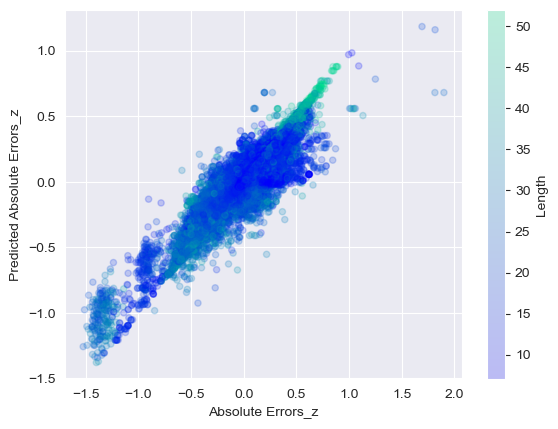

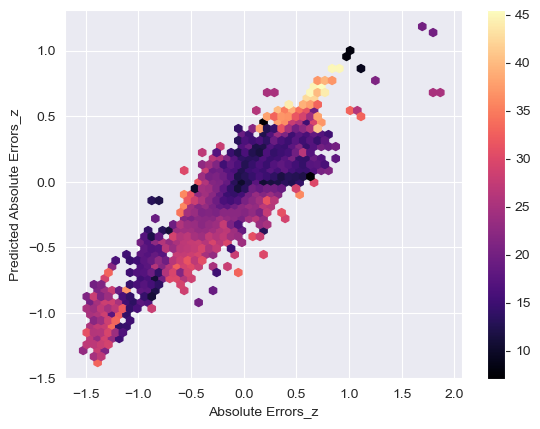

In [127]:
# Create a scatter plot of the error between the predicted and actual CCS values by sequence length. X = Experimental CCS, Y = Predicted CCS, Color = Sequence Length, Colormap = cool, alpha = 0.01
mb_clean_frame.plot.scatter(
    x='Absolute Errors_z',
    y='Predicted Absolute Errors_z',
    c='Length',
    cmap='winter',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)
mb_clean_frame.plot.hexbin(
    x='Absolute Errors_z',
    y='Predicted Absolute Errors_z',
    C='Length',
    reduce_C_function=np.mean,
    gridsize=50,
    cmap='magma'
)

# Print the Spearman's correlation coefficient between the predicted and actual CCS values
print("Spearman's Correlation Coefficient:", mb_clean_frame['Absolute Errors_z'].corr(mb_clean_frame['Predicted Absolute Errors_z'], method='spearman'))


Spearman's Correlation Coefficient: 0.5153158563743676


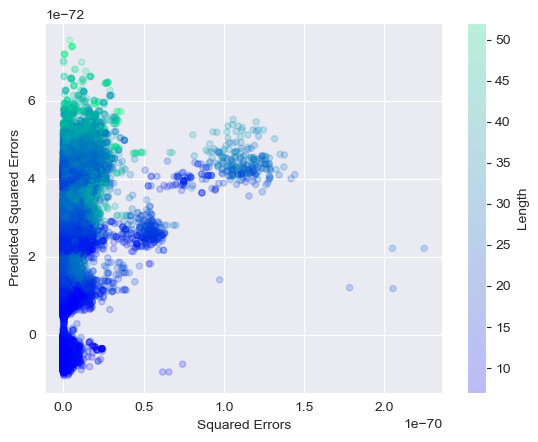

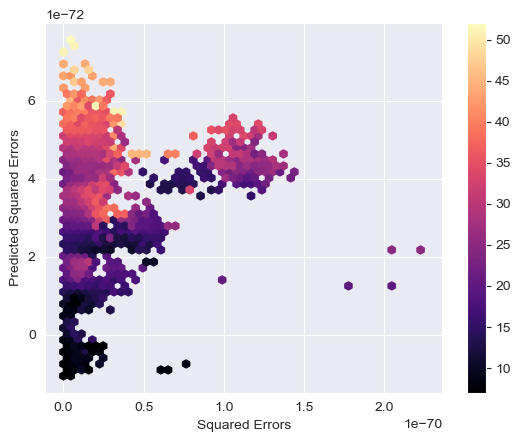

In [103]:
# Create a scatter plot of the error between the predicted and actual CCS values by sequence length. X = Experimental CCS, Y = Predicted CCS, Color = Sequence Length, Colormap = cool, alpha = 0.01
mb_clean_frame.plot.scatter(
    x='Squared Errors',
    y='Predicted Squared Errors_z',
    c='Length',
    cmap='winter',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)
mb_clean_frame.plot.hexbin(
    x='Squared Errors',
    y='Predicted Squared Errors_z',
    C='Length',
    reduce_C_function=np.mean,
    gridsize=50,
    cmap='magma'
)

# Print the Spearman's correlation coefficient between the predicted and actual CCS values
print("Spearman's Correlation Coefficient:", mb_clean_frame['Squared Errors_z'].corr(mb_clean_frame['Predicted Squared Errors_z'], method='spearman'))


Now: Train a new model with adjusted parameters based on error prediction. First: LinReg

In [144]:
# Split data into input and output variables
X = mb_clean_frame[['Mass', 'Charge', 'Length']]
y = mb_clean_frame['CCS_z'] - mb_clean_frame['Predicted Absolute Errors_z']
# Define the number of folds
k = 4

In [151]:
# Start logging time
start_time = time.time()
# Initialize K-fold object
k_fold = KFold(n_splits=k)

# Initialize lists to store statistics for each fold
mse_scores = []
median_relative_errors = []
r2_scores = []

# Perform k-fold cross validation
for train_index, test_index in k_fold.split(X):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create a lin reg regression model
    model = LinearRegression(n_jobs=-1)

    # train model
    model.fit(X_train, y_train)

    # make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the MSE for the current fold
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    # Calculate the median relative error for the current fold
    relative_errors = np.abs((y_pred - y_test) / y_test)
    median_relative_error = np.median(relative_errors)
    median_relative_errors.append(median_relative_error)
    # Calculate the R^2 score for the current fold
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    # Progress update
    print("Fold:", len(mse_scores))

# Create the final model
final_model = LinearRegression(n_jobs=-1)
final_model.fit(X, y)
# Print all mse scores
#print("All Mean Squared Errors:", mse_scores)
# Average the MSE scores
average_mse = np.mean(mse_scores)
# Print the average MSE score
print("Average Mean Squared Error:", average_mse)
print(mse_scores)
# Print the median of the relative errors for each fold
#print("Median Relative Errors:", median_relative_errors)
# print the average of the median relative errors
print("Average Median Relative Error:", np.mean(median_relative_errors))
print(median_relative_errors)
# Print the R^2 scores for each fold
#print("R^2 Scores:", r2_score)
# Print the average R^2 score
print("Average R^2 Score:", np.mean(r2_scores))
print(r2_scores)
# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Print the elapsed time
print(f'Time elapsed: {elapsed_time:.2f} seconds')

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 0.0017249255529922414
[0.0017453442451345917, 0.0017225779034008395, 0.0017561433289619958, 0.0016756367344715382]
Average Median Relative Error: 0.015264835525035204
[0.015319082888342658, 0.01527307400451366, 0.01527322647547735, 0.015193958731807147]
Average R^2 Score: 0.9982492707808363
[0.998218754992169, 0.9982535507118283, 0.9982169262244508, 0.9983078511948967]
Time elapsed: 0.20 seconds


In [146]:
mb_clean_frame['Predicted CCS_z EnsembleMethod'] = final_model.predict(X)

Spearman's Correlation Coefficient: 0.9999997791072145


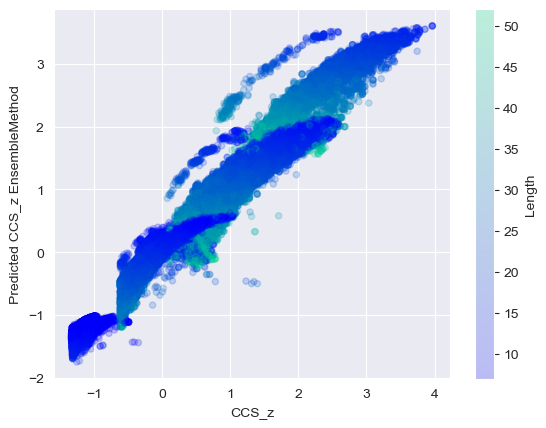

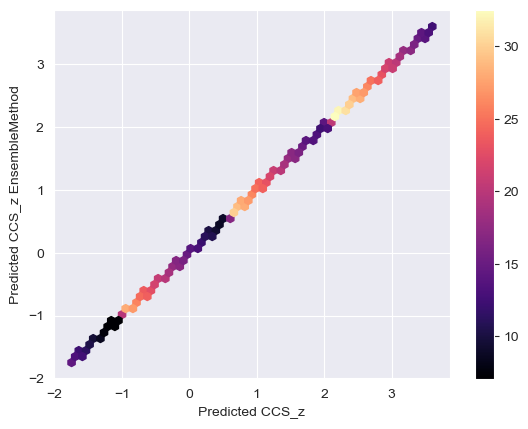

In [147]:
# Create a scatter plot of the error between the predicted and actual CCS values by sequence length. X = Experimental CCS, Y = Predicted CCS, Color = Sequence Length, Colormap = cool, alpha = 0.01
mb_clean_frame.plot.scatter(
    x='CCS_z',
    y='Predicted CCS_z EnsembleMethod',
    c='Length',
    cmap='winter',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)
mb_clean_frame.plot.hexbin(
    x='Predicted CCS_z',
    y='Predicted CCS_z EnsembleMethod',
    C='Length',
    reduce_C_function=np.mean,
    gridsize=50,
    cmap='magma'
)

# Print the Spearman's correlation coefficient between the predicted and actual CCS values
print("Spearman's Correlation Coefficient:", mb_clean_frame['Predicted CCS_z'].corr(mb_clean_frame['Predicted CCS_z EnsembleMethod'], method='spearman'))

Reverse z-score for predictions

In [149]:
mean = mb_clean_frame['Predicted CCS_z EnsembleMethod'].mean()
std = mb_clean_frame['Predicted CCS_z EnsembleMethod'].std()


mb_clean_frame['Predicted CCS EnsembleMethod'] = (mb_clean_frame['Predicted CCS_z EnsembleMethod']* std + mean

In [150]:
mb_clean_frame

,Sequence,m/z,CCS,Mass,Charge,Length,CCS_z,Predicted CCS_z,Predicted CCS,Absolute Errors_z,Squared Errors_z,Predicted Absolute Errors,Predicted Squared Errors,Predicted Absolute Errors_z,Absolute Errors,Squared Errors,Predicted CCS_z EnsembleMethod,Predicted CCS EnsembleMethod
67932,DWFILDHVSFDTLR,882.441212,1.493938e-35,1762.867870,2,14,-0.137390,-0.072192,1.545415e-35,-0.065198,0.004251,-9.096339e-41,8.606809e-73,-0.061020,-5.147721e-37,2.649903e-73,-0.072487,-0.071717
326165,QRPTNGKNDGQR,685.847813,1.708089e-35,1369.681070,2,12,0.133841,0.170938,1.737379e-35,-0.037097,0.001376,-9.096339e-41,1.039355e-72,-0.043892,-2.929035e-37,8.579248e-74,0.171158,0.169923
379127,TLFSTHYHSLVEDYSQNVAVR,822.739789,2.534496e-35,2465.197540,3,21,1.180520,1.208821,2.556842e-35,-0.028301,0.000801,-9.096339e-41,2.703462e-72,0.011137,-2.234597e-37,4.993426e-74,1.208599,1.198829
67996,DWLVPETFTK,412.548406,3.333980e-35,1234.623390,3,10,2.193100,2.008750,3.188428e-35,0.184349,0.033985,-9.096339e-41,2.306101e-72,0.135988,1.455516e-36,2.118526e-72,2.009075,1.992720
202778,KVEEDLK,860.472374,6.068834e-36,859.465098,1,7,-1.260881,-1.237283,6.255146e-36,-0.023599,0.000557,-9.096339e-41,-6.843437e-73,-0.017841,-1.863122e-37,3.471222e-74,-1.237158,-1.226806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73349,EDFEEAR,895.379202,6.106416e-36,894.371926,1,7,-1.256121,-1.257407,6.096254e-36,0.001286,0.000002,-9.096339e-41,-7.360350e-73,-0.000018,1.016207e-38,1.032676e-76,-1.257367,-1.246849
371403,TEDEAVYKAK,577.290411,1.899919e-35,1152.566270,2,10,0.376802,0.312560,1.849197e-35,0.064242,0.004127,-9.096339e-41,9.572959e-73,0.066381,5.072249e-37,2.572771e-73,0.312863,0.310462
312201,PWRAFFK,476.263605,2.012036e-35,950.512657,2,7,0.518803,0.453724,1.960654e-35,0.065079,0.004235,-9.096339e-41,6.511484e-73,0.090752,5.138274e-37,2.640186e-73,0.453849,0.450289
267336,MVNPTVFFDIAVDGEPLGR,1039.024780,1.387200e-35,2076.035010,2,19,-0.272578,-0.293867,1.370391e-35,0.021289,0.000453,-9.096339e-41,1.405858e-72,0.016491,1.680913e-37,2.825469e-74,-0.293807,-0.291216
